In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
features = iris.data
target = iris.target

sepal_length = np.array(features[:,0])
petal_width = np.array(features[:,3])

species_map = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
species_names = [species_map[i] for i in target]

In [3]:
def predict(intercept, coefficient, x):
  return intercept + coefficient * x

In [4]:
def rms(past_values, current_value, momentum=0.9, eps=1e-8):
    average = momentum * np.mean(past_values ** 2) + (1 - momentum) * current_value ** 2
    return np.sqrt(average + eps)

In [5]:
def adadelta(x, y, df, epochs=100):
    intercept, coefficient = -0.5, -0.75
    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    error = prediction - y[random_index]
    df.loc[0] = [intercept, coefficient, error, error * x[random_index], (error ** 2) / 2]
    
    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        error = prediction - y[random_index]

        new_intercept_gradient = error
        new_coefficient_gradient = error * x[random_index]

        intercept_rms = rms(df['intercept'].values[:epoch], intercept)
        coefficient_rms = rms(df['coefficient'].values[:epoch], coefficient)

        intercept_gradient_rms = rms(df['intercept_gradient'].values, new_intercept_gradient)
        coefficient_gradient_rms = rms(df['coefficient_gradient'].values, new_coefficient_gradient)

        delta_intercept = -(intercept_rms / intercept_gradient_rms) * new_intercept_gradient
        delta_coefficient = -(coefficient_rms / coefficient_gradient_rms) * new_coefficient_gradient

        intercept += delta_intercept
        coefficient += delta_coefficient

        mse = (error ** 2) / 2

        df.loc[epoch] = [intercept, coefficient, new_intercept_gradient, new_coefficient_gradient, mse]

    return df

In [6]:
def sgd(x, y, df, epochs=100, alpha = 0.01):
    intercept, coefficient, mse = -0.5, -0.75, 0.0
    index = np.random.randint(0, len(x))
    prediction = predict(intercept, coefficient, x[index])
    mse = ((prediction - y[index]) ** 2) / 2
    df.loc[0] = [intercept, coefficient, mse]

    for i in range(1, epochs):
        # get random index
        index = np.random.randint(0, len(x))
        # get random x and y
        x_i, y_i = x[index], y[index]
        # get prediction
        prediction = predict(intercept, coefficient, x_i)
        b0_error = prediction - y_i
        b1_error = (prediction - y_i) * x_i

        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error 

        mse = ((prediction - y_i) ** 2) / 2
        df.loc[i] = [intercept, coefficient, mse]
    return df

In [7]:
def adagrad(x, y, df, epochs = 100, learning_rate = 0.01, eps=1e-8):
    intercept, coefficient = -0.5, -0.75
    accumulated_squared_intercept = 0.0
    accumulated_squared_coefficient = 0.0

    random_index = np.random.randint(len(features))
    prediction = predict(intercept, coefficient, x[random_index])
    mse = ((prediction - y[random_index]) ** 2) / 2
    df.loc[0] = [intercept, coefficient, mse]

    for epoch in range(1, epochs + 1):
        random_index = np.random.randint(len(features))
        prediction = predict(intercept, coefficient, x[random_index])
        error = prediction - y[random_index]

        intercept_gradient = error
        coefficient_gradient = error * x[random_index]

        accumulated_squared_intercept += intercept_gradient ** 2
        accumulated_squared_coefficient += coefficient_gradient ** 2

        intercept -= (learning_rate / np.sqrt(accumulated_squared_intercept + eps)) * intercept_gradient
        coefficient -= (learning_rate / np.sqrt(accumulated_squared_coefficient + eps)) * coefficient_gradient

        mse = (error ** 2) / 2
        df.loc[epoch] = [intercept, coefficient, mse]

    return df

In [8]:
sgd_columns = ['intercept', 'coefficient', 'mse']
sgd_df = pd.DataFrame(columns=sgd_columns)
sgd_df = sgd(sepal_length, petal_width, sgd_df)

In [9]:
adadelta_columns = ['intercept', 'coefficient', 'intercept_gradient', 'coefficient_gradient', 'mse']
adadelta_df = pd.DataFrame(columns=adadelta_columns)
adadelta_df = adadelta(sepal_length, petal_width, adadelta_df)

adadelta_df.head()

,intercept,coefficient,intercept_gradient,coefficient_gradient,mse
0,-0.500000,-0.750000,-7.775000,-53.647500,30.225313
1,-0.023328,-0.072969,-7.375000,-47.937500,27.195312
2,0.107730,0.129887,-2.826817,-19.505037,3.995447
3,0.161661,0.206347,-1.160995,-7.430367,0.673955
4,0.107888,0.141721,1.096568,6.031125,0.601231


In [10]:
adagrad_columns = ['intercept', 'coefficient', 'mse']
adagrad_df = pd.DataFrame(columns=adagrad_columns)
adagrad_df = adagrad(sepal_length, petal_width, adagrad_df)

adagrad_df.head()

,intercept,coefficient,mse
0,-0.500000,-0.750000,22.781250
1,-0.490000,-0.740000,30.615313
2,-0.483595,-0.733769,21.294338
3,-0.480011,-0.731282,7.652572
4,-0.475393,-0.727355,16.146401


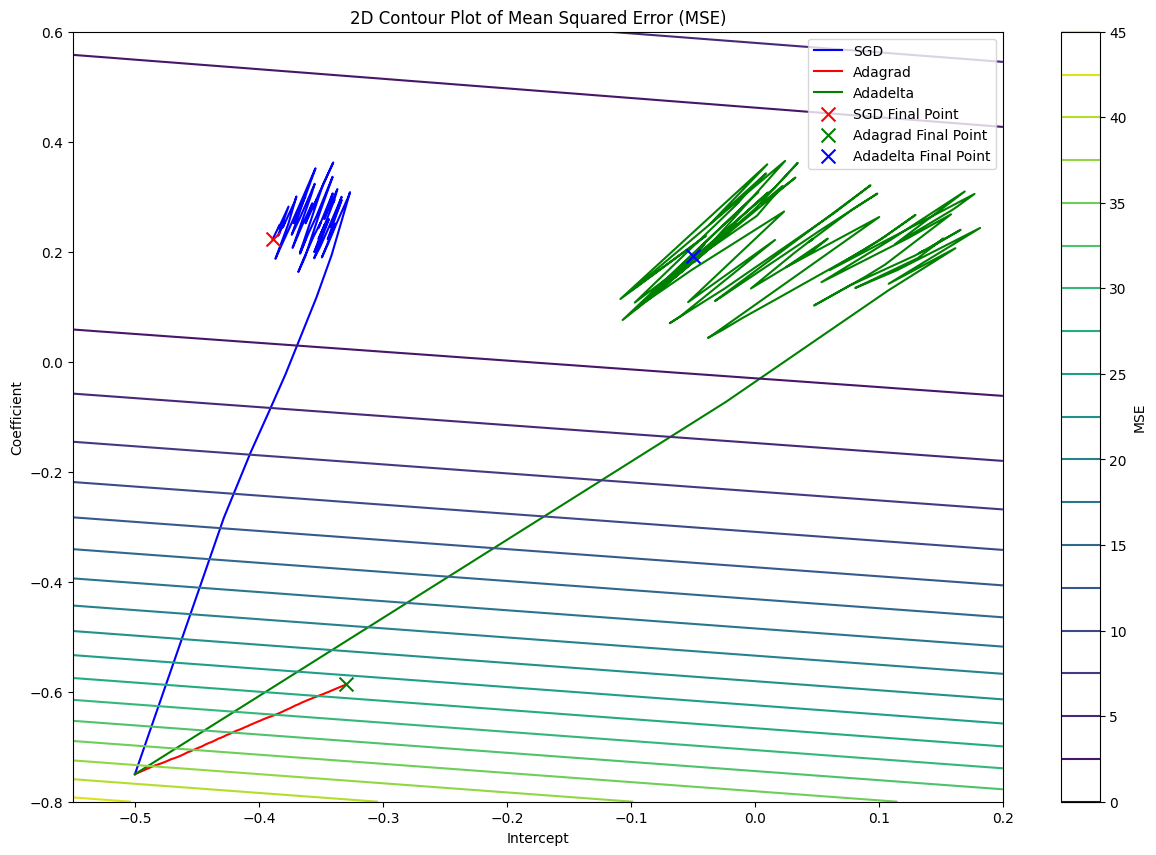

In [15]:
intercept_range = np.linspace(-0.55, 0.2, 150)
coefficient_range = np.linspace(-0.8, 0.6, 150)
intercept_grid, coefficient_grid = np.meshgrid(intercept_range, coefficient_range)

mse_grid = np.zeros_like(intercept_grid)

for i in range(len(intercept_range)):
    for j in range(len(coefficient_range)):
        # Get current intercept and coefficient values
        intercept = intercept_grid[i, j]
        coefficient = coefficient_grid[i, j]
        
        # Calculate predicted values using the current intercept and coefficient
        y_pred = intercept + coefficient * sepal_length.squeeze()
        
        # Calculate MSE (Mean Squared Error)
        mse = np.mean((y_pred - petal_width)**2)
        
        # Store MSE in the corresponding grid position
        mse_grid[i, j] = mse

plt.figure(figsize=(15, 10))
contour = plt.contour(intercept_grid, coefficient_grid, mse_grid, levels=20, cmap='viridis')
plt.colorbar(contour, label='MSE')
plt.plot(sgd_df['intercept'], sgd_df['coefficient'], color='b', zorder=1, label="SGD")
plt.plot(adagrad_df['intercept'], adagrad_df['coefficient'], color='r', zorder=1, label="Adagrad")
plt.plot(adadelta_df['intercept'], adadelta_df['coefficient'], color='g', zorder=1, label="Adadelta")
plt.xlabel('Intercept')
plt.ylabel('Coefficient')
plt.title('2D Contour Plot of Mean Squared Error (MSE)')
plt.scatter(sgd_df.loc[len(sgd_df)-1, 'intercept'], sgd_df.loc[len(sgd_df)-1, 'coefficient'], color='r', marker='x', s=100, zorder=2, label='SGD Final Point')
plt.scatter(adagrad_df.loc[len(adagrad_df)-1, 'intercept'], adagrad_df.loc[len(adagrad_df)-1, 'coefficient'], color='g', marker='x', s=100, zorder=2, label='Adagrad Final Point')
plt.scatter(adadelta_df.loc[len(adadelta_df)-1, 'intercept'], adadelta_df.loc[len(adadelta_df)-1, 'coefficient'], color='b', marker='x', s=100, zorder=2, label='Adadelta Final Point')
plt.legend()
plt.show()